# Anomalous Sound Detection via Wav2Vec2 Autoencoder (Offline Embeddings)
Precompute Wav2Vec2 embeddings for each audio file to `.npy`, then train an AE on those embeddings.

In [1]:
# Uncomment to install dependencies
# !pip install torch torchaudio librosa tqdm scikit-learn


In [2]:
import os, glob
import torch
from torch import nn
import torchaudio
import matplotlib.pyplot as plt
import librosa, librosa.display
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import numpy as np

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## DATA Examination

In [ ]:

TRAIN_DIR = 'DATA/dev_data/dev_data/slider/train'
TEST_DIR  = 'DATA/dev_data/dev_data/slider/test'
train_files = sorted(glob.glob(os.path.join(TRAIN_DIR, '*.wav')))
test_files  = sorted(glob.glob(os.path.join(TEST_DIR,  '*.wav')))
print('Train samples:', len(train_files))
print('Test samples:', len(test_files))
print('Example files:', train_files[:3])
total_dur = sum(librosa.get_duration(path=f) for f in tqdm(train_files, desc='Duration'))
print(f'Total train duration: {total_dur/3600:.2f} h')

Train samples: 2370
Test samples: 1101
Example files: ['DATA/dev_data/dev_data/slider/train\\normal_id_00_00000000.wav', 'DATA/dev_data/dev_data/slider/train\\normal_id_00_00000001.wav', 'DATA/dev_data/dev_data/slider/train\\normal_id_00_00000002.wav']


Duration: 100%|██████████| 2370/2370 [00:01<00:00, 1477.61it/s]

Total train duration: 6.58 h


## Pretrained Wav2Vec2 Encoder

In [5]:
bundle = torchaudio.pipelines.WAV2VEC2_BASE
wav2vec = bundle.get_model().to(DEVICE)
wav2vec.eval()
print(wav2vec)

Wav2Vec2Model(
  (feature_extractor): FeatureExtractor(
    (conv_layers): ModuleList(
      (0): ConvLayerBlock(
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      )
      (1-4): 4 x ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (5-6): 2 x ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      )
    )
  )
  (encoder): Encoder(
    (feature_projection): FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (pos_conv_embed): ConvolutionalPositionalEmbedding(
        (conv): ParametrizedConv1d(
          768, 768, kernel_size=(128,), stride=(1,), padding=(64,), groups=16
          (parametriza

## Offline Embeddings Generation

In [6]:
EMB_DIR = 'DATA/embeddings'
os.makedirs(f'{EMB_DIR}/train', exist_ok=True)
os.makedirs(f'{EMB_DIR}/test',  exist_ok=True)

for split, files in [('train', train_files), ('test', test_files)]:
    out_folder = os.path.join(EMB_DIR, split)
    for wav in tqdm(files, desc=f'Emb {split}', leave=False):
        out_npy = os.path.join(out_folder, os.path.basename(wav).replace('.wav', '.npy'))
        if os.path.exists(out_npy): continue
        y, sr = torchaudio.load(wav)
        y = y.to(DEVICE)
        with torch.inference_mode():
            feats, _ = wav2vec(y)
        mean_feat = feats.mean(dim=1).squeeze(0).cpu().numpy()  # [768]
        np.save(out_npy, mean_feat)

## Embedding Dataset & DataLoader

In [7]:
class EmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, folder):
        self.files = sorted(glob.glob(os.path.join(folder, '*.npy')))
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        emb = np.load(self.files[idx])  # [768]
        x = torch.tensor(emb, dtype=torch.float32)
        label = 0 if 'normal' in self.files[idx].lower() else 1
        return x, label

train_emb_ds = EmbeddingDataset(f'{EMB_DIR}/train')
test_emb_ds  = EmbeddingDataset(f'{EMB_DIR}/test')
train_dl = torch.utils.data.DataLoader(train_emb_ds, batch_size=64, shuffle=True, num_workers=0)
test_dl  = torch.utils.data.DataLoader(test_emb_ds,  batch_size=64, shuffle=False, num_workers=0)

## Feature Autoencoder (MLP)

In [8]:
FEAT_DIM = 768
HIDDEN = 256
class FeatureAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(FEAT_DIM, HIDDEN), nn.ReLU())
        self.dec = nn.Linear(HIDDEN, FEAT_DIM)
    def forward(self, x): return self.dec(self.enc(x))

ae = FeatureAE().to(DEVICE)
print(ae)

FeatureAE(
  (enc): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): ReLU()
  )
  (dec): Linear(in_features=256, out_features=768, bias=True)
)


## Training Loop on Embeddings

In [10]:
opt = torch.optim.Adam(ae.parameters(), lr=1e-3)
crit = nn.MSELoss()
EPOCHS = 500
history = []

for ep in range(1, EPOCHS+1):
    ae.train()
    total_loss = 0.0
    for x, _ in tqdm(train_dl, desc=f'Epoch {ep}/{EPOCHS}'):
        x = x.to(DEVICE)
        opt.zero_grad()
        recon = ae(x)
        loss = crit(recon, x)
        loss.backward()
        opt.step()
        total_loss += loss.item() * x.size(0)
    avg = total_loss / len(train_emb_ds)
    history.append(avg)
    print(f'Epoch {ep}: loss={avg:.4f}')

Epoch 1/500: 100%|██████████| 38/38 [00:00<00:00, 49.50it/s]


Epoch 1: loss=0.0034


Epoch 2/500: 100%|██████████| 38/38 [00:00<00:00, 50.08it/s]


Epoch 2: loss=0.0023


Epoch 3/500: 100%|██████████| 38/38 [00:00<00:00, 50.17it/s]


Epoch 3: loss=0.0022


Epoch 4/500: 100%|██████████| 38/38 [00:00<00:00, 51.05it/s]


Epoch 4: loss=0.0021


Epoch 5/500: 100%|██████████| 38/38 [00:00<00:00, 48.41it/s]


Epoch 5: loss=0.0020


Epoch 6/500: 100%|██████████| 38/38 [00:00<00:00, 50.33it/s]


Epoch 6: loss=0.0018


Epoch 7/500: 100%|██████████| 38/38 [00:00<00:00, 50.48it/s]


Epoch 7: loss=0.0018


Epoch 8/500: 100%|██████████| 38/38 [00:00<00:00, 50.75it/s]


Epoch 8: loss=0.0017


Epoch 9/500: 100%|██████████| 38/38 [00:00<00:00, 50.96it/s]


Epoch 9: loss=0.0016


Epoch 10/500: 100%|██████████| 38/38 [00:00<00:00, 51.75it/s]


Epoch 10: loss=0.0016


Epoch 11/500: 100%|██████████| 38/38 [00:00<00:00, 50.65it/s]


Epoch 11: loss=0.0015


Epoch 12/500: 100%|██████████| 38/38 [00:00<00:00, 49.91it/s]


Epoch 12: loss=0.0014


Epoch 13/500: 100%|██████████| 38/38 [00:00<00:00, 50.52it/s]


Epoch 13: loss=0.0014


Epoch 14/500: 100%|██████████| 38/38 [00:00<00:00, 50.68it/s]


Epoch 14: loss=0.0014


Epoch 15/500: 100%|██████████| 38/38 [00:00<00:00, 49.55it/s]


Epoch 15: loss=0.0013


Epoch 16/500: 100%|██████████| 38/38 [00:00<00:00, 51.64it/s]


Epoch 16: loss=0.0012


Epoch 17/500: 100%|██████████| 38/38 [00:00<00:00, 50.30it/s]


Epoch 17: loss=0.0012


Epoch 18/500: 100%|██████████| 38/38 [00:00<00:00, 50.40it/s]


Epoch 18: loss=0.0013


Epoch 19/500: 100%|██████████| 38/38 [00:00<00:00, 50.68it/s]


Epoch 19: loss=0.0012


Epoch 20/500: 100%|██████████| 38/38 [00:00<00:00, 50.58it/s]


Epoch 20: loss=0.0014


Epoch 21/500: 100%|██████████| 38/38 [00:00<00:00, 51.67it/s]


Epoch 21: loss=0.0012


Epoch 22/500: 100%|██████████| 38/38 [00:00<00:00, 51.40it/s]


Epoch 22: loss=0.0010


Epoch 23/500: 100%|██████████| 38/38 [00:00<00:00, 49.04it/s]


Epoch 23: loss=0.0010


Epoch 24/500: 100%|██████████| 38/38 [00:00<00:00, 49.15it/s]


Epoch 24: loss=0.0010


Epoch 25/500: 100%|██████████| 38/38 [00:00<00:00, 50.85it/s]


Epoch 25: loss=0.0010


Epoch 26/500: 100%|██████████| 38/38 [00:00<00:00, 50.41it/s]


Epoch 26: loss=0.0010


Epoch 27/500: 100%|██████████| 38/38 [00:00<00:00, 51.44it/s]


Epoch 27: loss=0.0010


Epoch 28/500: 100%|██████████| 38/38 [00:00<00:00, 50.99it/s]


Epoch 28: loss=0.0009


Epoch 29/500: 100%|██████████| 38/38 [00:00<00:00, 50.01it/s]


Epoch 29: loss=0.0009


Epoch 30/500: 100%|██████████| 38/38 [00:00<00:00, 50.28it/s]


Epoch 30: loss=0.0009


Epoch 31/500: 100%|██████████| 38/38 [00:00<00:00, 50.42it/s]


Epoch 31: loss=0.0009


Epoch 32/500: 100%|██████████| 38/38 [00:00<00:00, 51.10it/s]


Epoch 32: loss=0.0009


Epoch 33/500: 100%|██████████| 38/38 [00:00<00:00, 50.76it/s]


Epoch 33: loss=0.0008


Epoch 34/500: 100%|██████████| 38/38 [00:00<00:00, 51.51it/s]


Epoch 34: loss=0.0009


Epoch 35/500: 100%|██████████| 38/38 [00:00<00:00, 50.76it/s]


Epoch 35: loss=0.0009


Epoch 36/500: 100%|██████████| 38/38 [00:00<00:00, 51.01it/s]


Epoch 36: loss=0.0008


Epoch 37/500: 100%|██████████| 38/38 [00:00<00:00, 50.66it/s]


Epoch 37: loss=0.0008


Epoch 38/500: 100%|██████████| 38/38 [00:00<00:00, 48.42it/s]


Epoch 38: loss=0.0009


Epoch 39/500: 100%|██████████| 38/38 [00:00<00:00, 50.77it/s]


Epoch 39: loss=0.0009


Epoch 40/500: 100%|██████████| 38/38 [00:00<00:00, 48.97it/s]


Epoch 40: loss=0.0008


Epoch 41/500: 100%|██████████| 38/38 [00:00<00:00, 49.84it/s]


Epoch 41: loss=0.0008


Epoch 42/500: 100%|██████████| 38/38 [00:00<00:00, 51.04it/s]


Epoch 42: loss=0.0008


Epoch 43/500: 100%|██████████| 38/38 [00:00<00:00, 49.42it/s]


Epoch 43: loss=0.0007


Epoch 44/500: 100%|██████████| 38/38 [00:00<00:00, 49.57it/s]


Epoch 44: loss=0.0007


Epoch 45/500: 100%|██████████| 38/38 [00:00<00:00, 50.54it/s]


Epoch 45: loss=0.0007


Epoch 46/500: 100%|██████████| 38/38 [00:00<00:00, 51.34it/s]


Epoch 46: loss=0.0007


Epoch 47/500: 100%|██████████| 38/38 [00:00<00:00, 49.77it/s]


Epoch 47: loss=0.0007


Epoch 48/500: 100%|██████████| 38/38 [00:00<00:00, 50.98it/s]


Epoch 48: loss=0.0007


Epoch 49/500: 100%|██████████| 38/38 [00:00<00:00, 51.41it/s]


Epoch 49: loss=0.0007


Epoch 50/500: 100%|██████████| 38/38 [00:00<00:00, 51.92it/s]


Epoch 50: loss=0.0007


Epoch 51/500: 100%|██████████| 38/38 [00:00<00:00, 51.99it/s]


Epoch 51: loss=0.0007


Epoch 52/500: 100%|██████████| 38/38 [00:00<00:00, 50.74it/s]


Epoch 52: loss=0.0007


Epoch 53/500: 100%|██████████| 38/38 [00:00<00:00, 50.99it/s]


Epoch 53: loss=0.0007


Epoch 54/500: 100%|██████████| 38/38 [00:00<00:00, 51.17it/s]


Epoch 54: loss=0.0007


Epoch 55/500: 100%|██████████| 38/38 [00:00<00:00, 51.04it/s]


Epoch 55: loss=0.0007


Epoch 56/500: 100%|██████████| 38/38 [00:00<00:00, 50.77it/s]


Epoch 56: loss=0.0007


Epoch 57/500: 100%|██████████| 38/38 [00:00<00:00, 50.54it/s]


Epoch 57: loss=0.0006


Epoch 58/500: 100%|██████████| 38/38 [00:00<00:00, 48.41it/s]


Epoch 58: loss=0.0007


Epoch 59/500: 100%|██████████| 38/38 [00:00<00:00, 50.35it/s]


Epoch 59: loss=0.0007


Epoch 60/500: 100%|██████████| 38/38 [00:00<00:00, 50.87it/s]


Epoch 60: loss=0.0006


Epoch 61/500: 100%|██████████| 38/38 [00:00<00:00, 51.13it/s]


Epoch 61: loss=0.0006


Epoch 62/500: 100%|██████████| 38/38 [00:00<00:00, 51.97it/s]


Epoch 62: loss=0.0006


Epoch 63/500: 100%|██████████| 38/38 [00:00<00:00, 51.17it/s]


Epoch 63: loss=0.0006


Epoch 64/500: 100%|██████████| 38/38 [00:00<00:00, 52.58it/s]


Epoch 64: loss=0.0006


Epoch 65/500: 100%|██████████| 38/38 [00:00<00:00, 51.00it/s]


Epoch 65: loss=0.0006


Epoch 66/500: 100%|██████████| 38/38 [00:00<00:00, 51.15it/s]


Epoch 66: loss=0.0007


Epoch 67/500: 100%|██████████| 38/38 [00:00<00:00, 50.98it/s]


Epoch 67: loss=0.0007


Epoch 68/500: 100%|██████████| 38/38 [00:00<00:00, 49.92it/s]


Epoch 68: loss=0.0006


Epoch 69/500: 100%|██████████| 38/38 [00:00<00:00, 51.44it/s]


Epoch 69: loss=0.0006


Epoch 70/500: 100%|██████████| 38/38 [00:00<00:00, 49.63it/s]


Epoch 70: loss=0.0006


Epoch 71/500: 100%|██████████| 38/38 [00:00<00:00, 50.88it/s]


Epoch 71: loss=0.0006


Epoch 72/500: 100%|██████████| 38/38 [00:00<00:00, 50.67it/s]


Epoch 72: loss=0.0007


Epoch 73/500: 100%|██████████| 38/38 [00:00<00:00, 50.48it/s]


Epoch 73: loss=0.0006


Epoch 74/500: 100%|██████████| 38/38 [00:00<00:00, 51.86it/s]


Epoch 74: loss=0.0006


Epoch 75/500: 100%|██████████| 38/38 [00:00<00:00, 50.28it/s]


Epoch 75: loss=0.0006


Epoch 76/500: 100%|██████████| 38/38 [00:00<00:00, 51.01it/s]


Epoch 76: loss=0.0005


Epoch 77/500: 100%|██████████| 38/38 [00:00<00:00, 51.22it/s]


Epoch 77: loss=0.0006


Epoch 78/500: 100%|██████████| 38/38 [00:00<00:00, 50.00it/s]


Epoch 78: loss=0.0005


Epoch 79/500: 100%|██████████| 38/38 [00:00<00:00, 51.81it/s]


Epoch 79: loss=0.0005


Epoch 80/500: 100%|██████████| 38/38 [00:00<00:00, 50.68it/s]


Epoch 80: loss=0.0005


Epoch 81/500: 100%|██████████| 38/38 [00:00<00:00, 49.40it/s]


Epoch 81: loss=0.0005


Epoch 82/500: 100%|██████████| 38/38 [00:00<00:00, 48.78it/s]


Epoch 82: loss=0.0006


Epoch 83/500: 100%|██████████| 38/38 [00:00<00:00, 50.64it/s]


Epoch 83: loss=0.0006


Epoch 84/500: 100%|██████████| 38/38 [00:00<00:00, 50.71it/s]


Epoch 84: loss=0.0006


Epoch 85/500: 100%|██████████| 38/38 [00:00<00:00, 50.45it/s]


Epoch 85: loss=0.0005


Epoch 86/500: 100%|██████████| 38/38 [00:00<00:00, 51.02it/s]


Epoch 86: loss=0.0005


Epoch 87/500: 100%|██████████| 38/38 [00:00<00:00, 50.77it/s]


Epoch 87: loss=0.0005


Epoch 88/500: 100%|██████████| 38/38 [00:00<00:00, 49.34it/s]


Epoch 88: loss=0.0006


Epoch 89/500: 100%|██████████| 38/38 [00:00<00:00, 50.42it/s]


Epoch 89: loss=0.0006


Epoch 90/500: 100%|██████████| 38/38 [00:00<00:00, 50.94it/s]


Epoch 90: loss=0.0005


Epoch 91/500: 100%|██████████| 38/38 [00:00<00:00, 51.33it/s]


Epoch 91: loss=0.0005


Epoch 92/500: 100%|██████████| 38/38 [00:00<00:00, 51.42it/s]


Epoch 92: loss=0.0006


Epoch 93/500: 100%|██████████| 38/38 [00:00<00:00, 43.14it/s]


Epoch 93: loss=0.0006


Epoch 94/500: 100%|██████████| 38/38 [00:00<00:00, 50.22it/s]


Epoch 94: loss=0.0006


Epoch 95/500: 100%|██████████| 38/38 [00:00<00:00, 51.16it/s]


Epoch 95: loss=0.0006


Epoch 96/500: 100%|██████████| 38/38 [00:00<00:00, 52.10it/s]


Epoch 96: loss=0.0005


Epoch 97/500: 100%|██████████| 38/38 [00:00<00:00, 51.30it/s]


Epoch 97: loss=0.0005


Epoch 98/500: 100%|██████████| 38/38 [00:00<00:00, 51.50it/s]


Epoch 98: loss=0.0005


Epoch 99/500: 100%|██████████| 38/38 [00:00<00:00, 49.79it/s]


Epoch 99: loss=0.0005


Epoch 100/500: 100%|██████████| 38/38 [00:00<00:00, 51.00it/s]


Epoch 100: loss=0.0005


Epoch 101/500: 100%|██████████| 38/38 [00:00<00:00, 52.46it/s]


Epoch 101: loss=0.0005


Epoch 102/500: 100%|██████████| 38/38 [00:00<00:00, 52.09it/s]


Epoch 102: loss=0.0005


Epoch 103/500: 100%|██████████| 38/38 [00:00<00:00, 50.34it/s]


Epoch 103: loss=0.0005


Epoch 104/500: 100%|██████████| 38/38 [00:00<00:00, 49.70it/s]


Epoch 104: loss=0.0006


Epoch 105/500: 100%|██████████| 38/38 [00:00<00:00, 51.11it/s]


Epoch 105: loss=0.0005


Epoch 106/500: 100%|██████████| 38/38 [00:00<00:00, 50.67it/s]


Epoch 106: loss=0.0006


Epoch 107/500: 100%|██████████| 38/38 [00:00<00:00, 51.38it/s]


Epoch 107: loss=0.0005


Epoch 108/500: 100%|██████████| 38/38 [00:00<00:00, 51.18it/s]


Epoch 108: loss=0.0005


Epoch 109/500: 100%|██████████| 38/38 [00:00<00:00, 50.51it/s]


Epoch 109: loss=0.0005


Epoch 110/500: 100%|██████████| 38/38 [00:00<00:00, 49.55it/s]


Epoch 110: loss=0.0005


Epoch 111/500: 100%|██████████| 38/38 [00:00<00:00, 49.87it/s]


Epoch 111: loss=0.0005


Epoch 112/500: 100%|██████████| 38/38 [00:00<00:00, 51.59it/s]


Epoch 112: loss=0.0005


Epoch 113/500: 100%|██████████| 38/38 [00:00<00:00, 51.83it/s]


Epoch 113: loss=0.0005


Epoch 114/500: 100%|██████████| 38/38 [00:00<00:00, 50.98it/s]


Epoch 114: loss=0.0005


Epoch 115/500: 100%|██████████| 38/38 [00:00<00:00, 51.55it/s]


Epoch 115: loss=0.0005


Epoch 116/500: 100%|██████████| 38/38 [00:00<00:00, 50.92it/s]


Epoch 116: loss=0.0005


Epoch 117/500: 100%|██████████| 38/38 [00:00<00:00, 50.75it/s]


Epoch 117: loss=0.0005


Epoch 118/500: 100%|██████████| 38/38 [00:00<00:00, 50.65it/s]


Epoch 118: loss=0.0005


Epoch 119/500: 100%|██████████| 38/38 [00:00<00:00, 51.58it/s]


Epoch 119: loss=0.0005


Epoch 120/500: 100%|██████████| 38/38 [00:00<00:00, 51.86it/s]


Epoch 120: loss=0.0005


Epoch 121/500: 100%|██████████| 38/38 [00:00<00:00, 49.24it/s]


Epoch 121: loss=0.0005


Epoch 122/500: 100%|██████████| 38/38 [00:00<00:00, 50.07it/s]


Epoch 122: loss=0.0005


Epoch 123/500: 100%|██████████| 38/38 [00:00<00:00, 51.63it/s]


Epoch 123: loss=0.0006


Epoch 124/500: 100%|██████████| 38/38 [00:00<00:00, 51.31it/s]


Epoch 124: loss=0.0005


Epoch 125/500: 100%|██████████| 38/38 [00:00<00:00, 51.07it/s]


Epoch 125: loss=0.0005


Epoch 126/500: 100%|██████████| 38/38 [00:00<00:00, 51.37it/s]


Epoch 126: loss=0.0005


Epoch 127/500: 100%|██████████| 38/38 [00:00<00:00, 51.24it/s]


Epoch 127: loss=0.0004


Epoch 128/500: 100%|██████████| 38/38 [00:00<00:00, 50.70it/s]


Epoch 128: loss=0.0005


Epoch 129/500: 100%|██████████| 38/38 [00:00<00:00, 52.21it/s]


Epoch 129: loss=0.0004


Epoch 130/500: 100%|██████████| 38/38 [00:00<00:00, 49.25it/s]


Epoch 130: loss=0.0004


Epoch 131/500: 100%|██████████| 38/38 [00:00<00:00, 45.01it/s]


Epoch 131: loss=0.0005


Epoch 132/500: 100%|██████████| 38/38 [00:00<00:00, 51.09it/s]


Epoch 132: loss=0.0005


Epoch 133/500: 100%|██████████| 38/38 [00:00<00:00, 50.66it/s]


Epoch 133: loss=0.0006


Epoch 134/500: 100%|██████████| 38/38 [00:00<00:00, 49.45it/s]


Epoch 134: loss=0.0005


Epoch 135/500: 100%|██████████| 38/38 [00:00<00:00, 52.48it/s]


Epoch 135: loss=0.0004


Epoch 136/500: 100%|██████████| 38/38 [00:00<00:00, 55.33it/s]


Epoch 136: loss=0.0005


Epoch 137/500: 100%|██████████| 38/38 [00:00<00:00, 55.40it/s]


Epoch 137: loss=0.0005


Epoch 138/500: 100%|██████████| 38/38 [00:00<00:00, 51.83it/s]


Epoch 138: loss=0.0005


Epoch 139/500: 100%|██████████| 38/38 [00:00<00:00, 50.77it/s]


Epoch 139: loss=0.0004


Epoch 140/500: 100%|██████████| 38/38 [00:00<00:00, 52.91it/s]


Epoch 140: loss=0.0005


Epoch 141/500: 100%|██████████| 38/38 [00:00<00:00, 46.75it/s]


Epoch 141: loss=0.0005


Epoch 142/500: 100%|██████████| 38/38 [00:00<00:00, 47.94it/s]


Epoch 142: loss=0.0005


Epoch 143/500: 100%|██████████| 38/38 [00:00<00:00, 48.91it/s]


Epoch 143: loss=0.0004


Epoch 144/500: 100%|██████████| 38/38 [00:01<00:00, 33.71it/s]


Epoch 144: loss=0.0004


Epoch 145/500: 100%|██████████| 38/38 [00:01<00:00, 37.26it/s]


Epoch 145: loss=0.0004


Epoch 146/500: 100%|██████████| 38/38 [00:00<00:00, 41.57it/s]


Epoch 146: loss=0.0005


Epoch 147/500: 100%|██████████| 38/38 [00:00<00:00, 47.49it/s]


Epoch 147: loss=0.0005


Epoch 148/500: 100%|██████████| 38/38 [00:00<00:00, 46.24it/s]


Epoch 148: loss=0.0005


Epoch 149/500: 100%|██████████| 38/38 [00:00<00:00, 46.98it/s]


Epoch 149: loss=0.0005


Epoch 150/500: 100%|██████████| 38/38 [00:00<00:00, 40.78it/s]


Epoch 150: loss=0.0005


Epoch 151/500: 100%|██████████| 38/38 [00:00<00:00, 46.68it/s]


Epoch 151: loss=0.0005


Epoch 152/500: 100%|██████████| 38/38 [00:00<00:00, 45.69it/s]


Epoch 152: loss=0.0005


Epoch 153/500: 100%|██████████| 38/38 [00:00<00:00, 48.50it/s]


Epoch 153: loss=0.0005


Epoch 154/500: 100%|██████████| 38/38 [00:00<00:00, 47.59it/s]


Epoch 154: loss=0.0005


Epoch 155/500: 100%|██████████| 38/38 [00:00<00:00, 46.31it/s]


Epoch 155: loss=0.0004


Epoch 156/500: 100%|██████████| 38/38 [00:00<00:00, 50.83it/s]


Epoch 156: loss=0.0004


Epoch 157/500: 100%|██████████| 38/38 [00:00<00:00, 51.91it/s]


Epoch 157: loss=0.0006


Epoch 158/500: 100%|██████████| 38/38 [00:00<00:00, 50.44it/s]


Epoch 158: loss=0.0005


Epoch 159/500: 100%|██████████| 38/38 [00:00<00:00, 50.04it/s]


Epoch 159: loss=0.0006


Epoch 160/500: 100%|██████████| 38/38 [00:00<00:00, 50.82it/s]


Epoch 160: loss=0.0005


Epoch 161/500: 100%|██████████| 38/38 [00:00<00:00, 51.84it/s]


Epoch 161: loss=0.0005


Epoch 162/500: 100%|██████████| 38/38 [00:00<00:00, 51.33it/s]


Epoch 162: loss=0.0005


Epoch 163/500: 100%|██████████| 38/38 [00:00<00:00, 51.45it/s]


Epoch 163: loss=0.0005


Epoch 164/500: 100%|██████████| 38/38 [00:00<00:00, 51.22it/s]


Epoch 164: loss=0.0005


Epoch 165/500: 100%|██████████| 38/38 [00:00<00:00, 52.32it/s]


Epoch 165: loss=0.0005


Epoch 166/500: 100%|██████████| 38/38 [00:00<00:00, 51.01it/s]


Epoch 166: loss=0.0005


Epoch 167/500: 100%|██████████| 38/38 [00:00<00:00, 51.05it/s]


Epoch 167: loss=0.0005


Epoch 168/500: 100%|██████████| 38/38 [00:00<00:00, 51.66it/s]


Epoch 168: loss=0.0005


Epoch 169/500: 100%|██████████| 38/38 [00:00<00:00, 51.95it/s]


Epoch 169: loss=0.0004


Epoch 170/500: 100%|██████████| 38/38 [00:00<00:00, 50.76it/s]


Epoch 170: loss=0.0004


Epoch 171/500: 100%|██████████| 38/38 [00:00<00:00, 52.87it/s]


Epoch 171: loss=0.0004


Epoch 172/500: 100%|██████████| 38/38 [00:00<00:00, 51.03it/s]


Epoch 172: loss=0.0004


Epoch 173/500: 100%|██████████| 38/38 [00:00<00:00, 52.84it/s]


Epoch 173: loss=0.0004


Epoch 174/500: 100%|██████████| 38/38 [00:00<00:00, 51.47it/s]


Epoch 174: loss=0.0004


Epoch 175/500: 100%|██████████| 38/38 [00:00<00:00, 51.85it/s]


Epoch 175: loss=0.0004


Epoch 176/500: 100%|██████████| 38/38 [00:00<00:00, 51.28it/s]


Epoch 176: loss=0.0004


Epoch 177/500: 100%|██████████| 38/38 [00:00<00:00, 51.42it/s]


Epoch 177: loss=0.0005


Epoch 178/500: 100%|██████████| 38/38 [00:00<00:00, 51.81it/s]


Epoch 178: loss=0.0005


Epoch 179/500: 100%|██████████| 38/38 [00:00<00:00, 51.20it/s]


Epoch 179: loss=0.0005


Epoch 180/500: 100%|██████████| 38/38 [00:00<00:00, 51.63it/s]


Epoch 180: loss=0.0005


Epoch 181/500: 100%|██████████| 38/38 [00:00<00:00, 49.63it/s]


Epoch 181: loss=0.0004


Epoch 182/500: 100%|██████████| 38/38 [00:00<00:00, 51.05it/s]


Epoch 182: loss=0.0004


Epoch 183/500: 100%|██████████| 38/38 [00:00<00:00, 50.73it/s]


Epoch 183: loss=0.0004


Epoch 184/500: 100%|██████████| 38/38 [00:00<00:00, 50.87it/s]


Epoch 184: loss=0.0004


Epoch 185/500: 100%|██████████| 38/38 [00:00<00:00, 51.28it/s]


Epoch 185: loss=0.0005


Epoch 186/500: 100%|██████████| 38/38 [00:00<00:00, 51.07it/s]


Epoch 186: loss=0.0005


Epoch 187/500: 100%|██████████| 38/38 [00:00<00:00, 51.19it/s]


Epoch 187: loss=0.0004


Epoch 188/500: 100%|██████████| 38/38 [00:00<00:00, 52.27it/s]


Epoch 188: loss=0.0005


Epoch 189/500: 100%|██████████| 38/38 [00:00<00:00, 50.71it/s]


Epoch 189: loss=0.0005


Epoch 190/500: 100%|██████████| 38/38 [00:00<00:00, 50.13it/s]


Epoch 190: loss=0.0005


Epoch 191/500: 100%|██████████| 38/38 [00:00<00:00, 51.34it/s]


Epoch 191: loss=0.0005


Epoch 192/500: 100%|██████████| 38/38 [00:00<00:00, 50.20it/s]


Epoch 192: loss=0.0004


Epoch 193/500: 100%|██████████| 38/38 [00:00<00:00, 51.01it/s]


Epoch 193: loss=0.0004


Epoch 194/500: 100%|██████████| 38/38 [00:00<00:00, 50.87it/s]


Epoch 194: loss=0.0004


Epoch 195/500: 100%|██████████| 38/38 [00:00<00:00, 52.29it/s]


Epoch 195: loss=0.0004


Epoch 196/500: 100%|██████████| 38/38 [00:00<00:00, 52.25it/s]


Epoch 196: loss=0.0004


Epoch 197/500: 100%|██████████| 38/38 [00:00<00:00, 49.73it/s]


Epoch 197: loss=0.0004


Epoch 198/500: 100%|██████████| 38/38 [00:00<00:00, 50.54it/s]


Epoch 198: loss=0.0004


Epoch 199/500: 100%|██████████| 38/38 [00:00<00:00, 50.89it/s]


Epoch 199: loss=0.0005


Epoch 200/500: 100%|██████████| 38/38 [00:00<00:00, 52.18it/s]


Epoch 200: loss=0.0005


Epoch 201/500: 100%|██████████| 38/38 [00:00<00:00, 51.60it/s]


Epoch 201: loss=0.0005


Epoch 202/500: 100%|██████████| 38/38 [00:00<00:00, 51.52it/s]


Epoch 202: loss=0.0004


Epoch 203/500: 100%|██████████| 38/38 [00:00<00:00, 49.78it/s]


Epoch 203: loss=0.0004


Epoch 204/500: 100%|██████████| 38/38 [00:00<00:00, 51.34it/s]


Epoch 204: loss=0.0004


Epoch 205/500: 100%|██████████| 38/38 [00:00<00:00, 50.46it/s]


Epoch 205: loss=0.0004


Epoch 206/500: 100%|██████████| 38/38 [00:00<00:00, 51.48it/s]


Epoch 206: loss=0.0004


Epoch 207/500: 100%|██████████| 38/38 [00:00<00:00, 50.70it/s]


Epoch 207: loss=0.0004


Epoch 208/500: 100%|██████████| 38/38 [00:00<00:00, 50.85it/s]


Epoch 208: loss=0.0004


Epoch 209/500: 100%|██████████| 38/38 [00:00<00:00, 51.72it/s]


Epoch 209: loss=0.0004


Epoch 210/500: 100%|██████████| 38/38 [00:00<00:00, 51.19it/s]


Epoch 210: loss=0.0005


Epoch 211/500: 100%|██████████| 38/38 [00:00<00:00, 51.43it/s]


Epoch 211: loss=0.0005


Epoch 212/500: 100%|██████████| 38/38 [00:00<00:00, 51.31it/s]


Epoch 212: loss=0.0005


Epoch 213/500: 100%|██████████| 38/38 [00:00<00:00, 51.65it/s]


Epoch 213: loss=0.0004


Epoch 214/500: 100%|██████████| 38/38 [00:00<00:00, 49.68it/s]


Epoch 214: loss=0.0005


Epoch 215/500: 100%|██████████| 38/38 [00:00<00:00, 50.99it/s]


Epoch 215: loss=0.0005


Epoch 216/500: 100%|██████████| 38/38 [00:00<00:00, 51.26it/s]


Epoch 216: loss=0.0004


Epoch 217/500: 100%|██████████| 38/38 [00:00<00:00, 52.10it/s]


Epoch 217: loss=0.0004


Epoch 218/500: 100%|██████████| 38/38 [00:00<00:00, 51.10it/s]


Epoch 218: loss=0.0004


Epoch 219/500: 100%|██████████| 38/38 [00:00<00:00, 51.38it/s]


Epoch 219: loss=0.0004


Epoch 220/500: 100%|██████████| 38/38 [00:00<00:00, 51.35it/s]


Epoch 220: loss=0.0004


Epoch 221/500: 100%|██████████| 38/38 [00:00<00:00, 51.21it/s]


Epoch 221: loss=0.0004


Epoch 222/500: 100%|██████████| 38/38 [00:00<00:00, 51.82it/s]


Epoch 222: loss=0.0005


Epoch 223/500: 100%|██████████| 38/38 [00:00<00:00, 51.21it/s]


Epoch 223: loss=0.0005


Epoch 224/500: 100%|██████████| 38/38 [00:00<00:00, 52.32it/s]


Epoch 224: loss=0.0004


Epoch 225/500: 100%|██████████| 38/38 [00:00<00:00, 48.66it/s]


Epoch 225: loss=0.0004


Epoch 226/500: 100%|██████████| 38/38 [00:00<00:00, 51.64it/s]


Epoch 226: loss=0.0004


Epoch 227/500: 100%|██████████| 38/38 [00:00<00:00, 51.84it/s]


Epoch 227: loss=0.0004


Epoch 228/500: 100%|██████████| 38/38 [00:00<00:00, 51.13it/s]


Epoch 228: loss=0.0004


Epoch 229/500: 100%|██████████| 38/38 [00:00<00:00, 51.59it/s]


Epoch 229: loss=0.0004


Epoch 230/500: 100%|██████████| 38/38 [00:00<00:00, 51.67it/s]


Epoch 230: loss=0.0004


Epoch 231/500: 100%|██████████| 38/38 [00:00<00:00, 51.12it/s]


Epoch 231: loss=0.0005


Epoch 232/500: 100%|██████████| 38/38 [00:00<00:00, 50.80it/s]


Epoch 232: loss=0.0004


Epoch 233/500: 100%|██████████| 38/38 [00:00<00:00, 51.14it/s]


Epoch 233: loss=0.0004


Epoch 234/500: 100%|██████████| 38/38 [00:00<00:00, 51.61it/s]


Epoch 234: loss=0.0004


Epoch 235/500: 100%|██████████| 38/38 [00:00<00:00, 51.14it/s]


Epoch 235: loss=0.0004


Epoch 236/500: 100%|██████████| 38/38 [00:00<00:00, 50.33it/s]


Epoch 236: loss=0.0004


Epoch 237/500: 100%|██████████| 38/38 [00:00<00:00, 50.94it/s]


Epoch 237: loss=0.0004


Epoch 238/500: 100%|██████████| 38/38 [00:00<00:00, 51.70it/s]


Epoch 238: loss=0.0004


Epoch 239/500: 100%|██████████| 38/38 [00:00<00:00, 50.84it/s]


Epoch 239: loss=0.0004


Epoch 240/500: 100%|██████████| 38/38 [00:00<00:00, 51.08it/s]


Epoch 240: loss=0.0005


Epoch 241/500: 100%|██████████| 38/38 [00:00<00:00, 51.00it/s]


Epoch 241: loss=0.0005


Epoch 242/500: 100%|██████████| 38/38 [00:00<00:00, 51.52it/s]


Epoch 242: loss=0.0004


Epoch 243/500: 100%|██████████| 38/38 [00:00<00:00, 51.14it/s]


Epoch 243: loss=0.0004


Epoch 244/500: 100%|██████████| 38/38 [00:00<00:00, 52.33it/s]


Epoch 244: loss=0.0004


Epoch 245/500: 100%|██████████| 38/38 [00:00<00:00, 51.18it/s]


Epoch 245: loss=0.0004


Epoch 246/500: 100%|██████████| 38/38 [00:00<00:00, 51.50it/s]


Epoch 246: loss=0.0004


Epoch 247/500: 100%|██████████| 38/38 [00:00<00:00, 49.85it/s]


Epoch 247: loss=0.0005


Epoch 248/500: 100%|██████████| 38/38 [00:00<00:00, 51.44it/s]


Epoch 248: loss=0.0005


Epoch 249/500: 100%|██████████| 38/38 [00:00<00:00, 51.87it/s]


Epoch 249: loss=0.0004


Epoch 250/500: 100%|██████████| 38/38 [00:00<00:00, 51.97it/s]


Epoch 250: loss=0.0005


Epoch 251/500: 100%|██████████| 38/38 [00:00<00:00, 51.35it/s]


Epoch 251: loss=0.0004


Epoch 252/500: 100%|██████████| 38/38 [00:00<00:00, 52.98it/s]


Epoch 252: loss=0.0005


Epoch 253/500: 100%|██████████| 38/38 [00:00<00:00, 51.16it/s]


Epoch 253: loss=0.0005


Epoch 254/500: 100%|██████████| 38/38 [00:00<00:00, 52.53it/s]


Epoch 254: loss=0.0004


Epoch 255/500: 100%|██████████| 38/38 [00:00<00:00, 52.93it/s]


Epoch 255: loss=0.0004


Epoch 256/500: 100%|██████████| 38/38 [00:00<00:00, 53.30it/s]


Epoch 256: loss=0.0004


Epoch 257/500: 100%|██████████| 38/38 [00:00<00:00, 51.49it/s]


Epoch 257: loss=0.0004


Epoch 258/500: 100%|██████████| 38/38 [00:00<00:00, 51.81it/s]


Epoch 258: loss=0.0004


Epoch 259/500: 100%|██████████| 38/38 [00:00<00:00, 53.08it/s]


Epoch 259: loss=0.0004


Epoch 260/500: 100%|██████████| 38/38 [00:00<00:00, 53.02it/s]


Epoch 260: loss=0.0004


Epoch 261/500: 100%|██████████| 38/38 [00:00<00:00, 52.93it/s]


Epoch 261: loss=0.0004


Epoch 262/500: 100%|██████████| 38/38 [00:00<00:00, 53.02it/s]


Epoch 262: loss=0.0004


Epoch 263/500: 100%|██████████| 38/38 [00:00<00:00, 51.81it/s]


Epoch 263: loss=0.0004


Epoch 264/500: 100%|██████████| 38/38 [00:00<00:00, 49.52it/s]


Epoch 264: loss=0.0005


Epoch 265/500: 100%|██████████| 38/38 [00:00<00:00, 51.87it/s]


Epoch 265: loss=0.0005


Epoch 266/500: 100%|██████████| 38/38 [00:00<00:00, 53.01it/s]


Epoch 266: loss=0.0004


Epoch 267/500: 100%|██████████| 38/38 [00:00<00:00, 51.85it/s]


Epoch 267: loss=0.0005


Epoch 268/500: 100%|██████████| 38/38 [00:00<00:00, 52.98it/s]


Epoch 268: loss=0.0005


Epoch 269/500: 100%|██████████| 38/38 [00:00<00:00, 53.06it/s]


Epoch 269: loss=0.0005


Epoch 270/500: 100%|██████████| 38/38 [00:00<00:00, 51.82it/s]


Epoch 270: loss=0.0005


Epoch 271/500: 100%|██████████| 38/38 [00:00<00:00, 51.82it/s]


Epoch 271: loss=0.0004


Epoch 272/500: 100%|██████████| 38/38 [00:00<00:00, 52.84it/s]


Epoch 272: loss=0.0004


Epoch 273/500: 100%|██████████| 38/38 [00:00<00:00, 53.16it/s]


Epoch 273: loss=0.0004


Epoch 274/500: 100%|██████████| 38/38 [00:00<00:00, 51.86it/s]


Epoch 274: loss=0.0004


Epoch 275/500: 100%|██████████| 38/38 [00:00<00:00, 51.92it/s]


Epoch 275: loss=0.0004


Epoch 276/500: 100%|██████████| 38/38 [00:00<00:00, 54.32it/s]


Epoch 276: loss=0.0004


Epoch 277/500: 100%|██████████| 38/38 [00:00<00:00, 53.00it/s]


Epoch 277: loss=0.0004


Epoch 278/500: 100%|██████████| 38/38 [00:00<00:00, 51.82it/s]


Epoch 278: loss=0.0004


Epoch 279/500: 100%|██████████| 38/38 [00:00<00:00, 53.02it/s]


Epoch 279: loss=0.0004


Epoch 280/500: 100%|██████████| 38/38 [00:00<00:00, 51.83it/s]


Epoch 280: loss=0.0004


Epoch 281/500: 100%|██████████| 38/38 [00:00<00:00, 51.80it/s]


Epoch 281: loss=0.0005


Epoch 282/500: 100%|██████████| 38/38 [00:00<00:00, 50.67it/s]


Epoch 282: loss=0.0005


Epoch 283/500: 100%|██████████| 38/38 [00:00<00:00, 53.02it/s]


Epoch 283: loss=0.0004


Epoch 284/500: 100%|██████████| 38/38 [00:00<00:00, 51.82it/s]


Epoch 284: loss=0.0005


Epoch 285/500: 100%|██████████| 38/38 [00:00<00:00, 53.02it/s]


Epoch 285: loss=0.0005


Epoch 286/500: 100%|██████████| 38/38 [00:00<00:00, 53.02it/s]


Epoch 286: loss=0.0004


Epoch 287/500: 100%|██████████| 38/38 [00:00<00:00, 53.10it/s]


Epoch 287: loss=0.0005


Epoch 288/500: 100%|██████████| 38/38 [00:00<00:00, 53.07it/s]


Epoch 288: loss=0.0004


Epoch 289/500: 100%|██████████| 38/38 [00:00<00:00, 43.85it/s]


Epoch 289: loss=0.0005


Epoch 290/500: 100%|██████████| 38/38 [00:00<00:00, 52.70it/s]


Epoch 290: loss=0.0004


Epoch 291/500: 100%|██████████| 38/38 [00:00<00:00, 52.70it/s]


Epoch 291: loss=0.0005


Epoch 292/500: 100%|██████████| 38/38 [00:00<00:00, 52.57it/s]


Epoch 292: loss=0.0005


Epoch 293/500: 100%|██████████| 38/38 [00:00<00:00, 52.18it/s]


Epoch 293: loss=0.0004


Epoch 294/500: 100%|██████████| 38/38 [00:00<00:00, 53.02it/s]


Epoch 294: loss=0.0005


Epoch 295/500: 100%|██████████| 38/38 [00:00<00:00, 52.86it/s]


Epoch 295: loss=0.0005


Epoch 296/500: 100%|██████████| 38/38 [00:00<00:00, 53.22it/s]


Epoch 296: loss=0.0005


Epoch 297/500: 100%|██████████| 38/38 [00:00<00:00, 51.80it/s]


Epoch 297: loss=0.0004


Epoch 298/500: 100%|██████████| 38/38 [00:00<00:00, 53.05it/s]


Epoch 298: loss=0.0004


Epoch 299/500: 100%|██████████| 38/38 [00:00<00:00, 52.64it/s]


Epoch 299: loss=0.0004


Epoch 300/500: 100%|██████████| 38/38 [00:00<00:00, 51.06it/s]


Epoch 300: loss=0.0004


Epoch 301/500: 100%|██████████| 38/38 [00:00<00:00, 53.03it/s]


Epoch 301: loss=0.0004


Epoch 302/500: 100%|██████████| 38/38 [00:00<00:00, 52.95it/s]


Epoch 302: loss=0.0004


Epoch 303/500: 100%|██████████| 38/38 [00:00<00:00, 53.03it/s]


Epoch 303: loss=0.0004


Epoch 304/500: 100%|██████████| 38/38 [00:00<00:00, 53.03it/s]


Epoch 304: loss=0.0004


Epoch 305/500: 100%|██████████| 38/38 [00:00<00:00, 52.78it/s]


Epoch 305: loss=0.0004


Epoch 306/500: 100%|██████████| 38/38 [00:00<00:00, 53.26it/s]


Epoch 306: loss=0.0005


Epoch 307/500: 100%|██████████| 38/38 [00:00<00:00, 53.05it/s]


Epoch 307: loss=0.0005


Epoch 308/500: 100%|██████████| 38/38 [00:00<00:00, 51.80it/s]


Epoch 308: loss=0.0004


Epoch 309/500: 100%|██████████| 38/38 [00:00<00:00, 54.11it/s]


Epoch 309: loss=0.0004


Epoch 310/500: 100%|██████████| 38/38 [00:00<00:00, 52.76it/s]


Epoch 310: loss=0.0004


Epoch 311/500: 100%|██████████| 38/38 [00:00<00:00, 53.48it/s]


Epoch 311: loss=0.0004


Epoch 312/500: 100%|██████████| 38/38 [00:00<00:00, 51.84it/s]


Epoch 312: loss=0.0004


Epoch 313/500: 100%|██████████| 38/38 [00:00<00:00, 53.04it/s]


Epoch 313: loss=0.0004


Epoch 314/500: 100%|██████████| 38/38 [00:00<00:00, 53.15it/s]


Epoch 314: loss=0.0004


Epoch 315/500: 100%|██████████| 38/38 [00:00<00:00, 53.02it/s]


Epoch 315: loss=0.0004


Epoch 316/500: 100%|██████████| 38/38 [00:00<00:00, 53.03it/s]


Epoch 316: loss=0.0004


Epoch 317/500: 100%|██████████| 38/38 [00:00<00:00, 51.71it/s]


Epoch 317: loss=0.0004


Epoch 318/500: 100%|██████████| 38/38 [00:00<00:00, 54.10it/s]


Epoch 318: loss=0.0004


Epoch 319/500: 100%|██████████| 38/38 [00:00<00:00, 53.01it/s]


Epoch 319: loss=0.0004


Epoch 320/500: 100%|██████████| 38/38 [00:00<00:00, 53.02it/s]


Epoch 320: loss=0.0004


Epoch 321/500: 100%|██████████| 38/38 [00:00<00:00, 50.67it/s]


Epoch 321: loss=0.0004


Epoch 322/500: 100%|██████████| 38/38 [00:00<00:00, 53.03it/s]


Epoch 322: loss=0.0004


Epoch 323/500: 100%|██████████| 38/38 [00:00<00:00, 52.05it/s]


Epoch 323: loss=0.0004


Epoch 324/500: 100%|██████████| 38/38 [00:00<00:00, 53.27it/s]


Epoch 324: loss=0.0004


Epoch 325/500: 100%|██████████| 38/38 [00:00<00:00, 53.04it/s]


Epoch 325: loss=0.0004


Epoch 326/500: 100%|██████████| 38/38 [00:00<00:00, 53.00it/s]


Epoch 326: loss=0.0004


Epoch 327/500: 100%|██████████| 38/38 [00:00<00:00, 52.78it/s]


Epoch 327: loss=0.0004


Epoch 328/500: 100%|██████████| 38/38 [00:00<00:00, 52.72it/s]


Epoch 328: loss=0.0005


Epoch 329/500: 100%|██████████| 38/38 [00:00<00:00, 52.36it/s]


Epoch 329: loss=0.0005


Epoch 330/500: 100%|██████████| 38/38 [00:00<00:00, 53.01it/s]


Epoch 330: loss=0.0004


Epoch 331/500: 100%|██████████| 38/38 [00:00<00:00, 52.80it/s]


Epoch 331: loss=0.0004


Epoch 332/500: 100%|██████████| 38/38 [00:00<00:00, 53.20it/s]


Epoch 332: loss=0.0005


Epoch 333/500: 100%|██████████| 38/38 [00:00<00:00, 51.84it/s]


Epoch 333: loss=0.0004


Epoch 334/500: 100%|██████████| 38/38 [00:00<00:00, 53.01it/s]


Epoch 334: loss=0.0004


Epoch 335/500: 100%|██████████| 38/38 [00:00<00:00, 48.54it/s]


Epoch 335: loss=0.0004


Epoch 336/500: 100%|██████████| 38/38 [00:00<00:00, 51.88it/s]


Epoch 336: loss=0.0004


Epoch 337/500: 100%|██████████| 38/38 [00:00<00:00, 53.11it/s]


Epoch 337: loss=0.0004


Epoch 338/500: 100%|██████████| 38/38 [00:00<00:00, 53.05it/s]


Epoch 338: loss=0.0004


Epoch 339/500: 100%|██████████| 38/38 [00:00<00:00, 52.99it/s]


Epoch 339: loss=0.0004


Epoch 340/500: 100%|██████████| 38/38 [00:00<00:00, 53.03it/s]


Epoch 340: loss=0.0004


Epoch 341/500: 100%|██████████| 38/38 [00:00<00:00, 51.91it/s]


Epoch 341: loss=0.0004


Epoch 342/500: 100%|██████████| 38/38 [00:00<00:00, 53.04it/s]


Epoch 342: loss=0.0004


Epoch 343/500: 100%|██████████| 38/38 [00:00<00:00, 53.15it/s]


Epoch 343: loss=0.0004


Epoch 344/500: 100%|██████████| 38/38 [00:00<00:00, 51.83it/s]


Epoch 344: loss=0.0004


Epoch 345/500: 100%|██████████| 38/38 [00:00<00:00, 53.03it/s]


Epoch 345: loss=0.0004


Epoch 346/500: 100%|██████████| 38/38 [00:00<00:00, 52.83it/s]


Epoch 346: loss=0.0004


Epoch 347/500: 100%|██████████| 38/38 [00:00<00:00, 52.02it/s]


Epoch 347: loss=0.0004


Epoch 348/500: 100%|██████████| 38/38 [00:00<00:00, 53.02it/s]


Epoch 348: loss=0.0004


Epoch 349/500: 100%|██████████| 38/38 [00:00<00:00, 53.02it/s]


Epoch 349: loss=0.0004


Epoch 350/500: 100%|██████████| 38/38 [00:00<00:00, 52.85it/s]


Epoch 350: loss=0.0004


Epoch 351/500: 100%|██████████| 38/38 [00:00<00:00, 53.02it/s]


Epoch 351: loss=0.0004


Epoch 352/500: 100%|██████████| 38/38 [00:00<00:00, 52.36it/s]


Epoch 352: loss=0.0005


Epoch 353/500: 100%|██████████| 38/38 [00:00<00:00, 51.44it/s]


Epoch 353: loss=0.0005


Epoch 354/500: 100%|██████████| 38/38 [00:00<00:00, 53.01it/s]


Epoch 354: loss=0.0004


Epoch 355/500: 100%|██████████| 38/38 [00:00<00:00, 51.82it/s]


Epoch 355: loss=0.0004


Epoch 356/500: 100%|██████████| 38/38 [00:00<00:00, 54.28it/s]


Epoch 356: loss=0.0005


Epoch 357/500: 100%|██████████| 38/38 [00:00<00:00, 53.02it/s]


Epoch 357: loss=0.0005


Epoch 358/500: 100%|██████████| 38/38 [00:00<00:00, 54.11it/s]


Epoch 358: loss=0.0004


Epoch 359/500: 100%|██████████| 38/38 [00:00<00:00, 53.02it/s]


Epoch 359: loss=0.0004


Epoch 360/500: 100%|██████████| 38/38 [00:00<00:00, 53.02it/s]


Epoch 360: loss=0.0004


Epoch 361/500: 100%|██████████| 38/38 [00:00<00:00, 53.03it/s]


Epoch 361: loss=0.0004


Epoch 362/500: 100%|██████████| 38/38 [00:00<00:00, 53.02it/s]


Epoch 362: loss=0.0004


Epoch 363/500: 100%|██████████| 38/38 [00:00<00:00, 53.07it/s]


Epoch 363: loss=0.0004


Epoch 364/500: 100%|██████████| 38/38 [00:00<00:00, 53.03it/s]


Epoch 364: loss=0.0004


Epoch 365/500: 100%|██████████| 38/38 [00:00<00:00, 51.81it/s]


Epoch 365: loss=0.0004


Epoch 366/500: 100%|██████████| 38/38 [00:00<00:00, 52.85it/s]


Epoch 366: loss=0.0004


Epoch 367/500: 100%|██████████| 38/38 [00:00<00:00, 53.02it/s]


Epoch 367: loss=0.0004


Epoch 368/500: 100%|██████████| 38/38 [00:00<00:00, 53.02it/s]


Epoch 368: loss=0.0004


Epoch 369/500: 100%|██████████| 38/38 [00:00<00:00, 53.02it/s]


Epoch 369: loss=0.0004


Epoch 370/500: 100%|██████████| 38/38 [00:00<00:00, 51.65it/s]


Epoch 370: loss=0.0004


Epoch 371/500: 100%|██████████| 38/38 [00:00<00:00, 52.90it/s]


Epoch 371: loss=0.0004


Epoch 372/500: 100%|██████████| 38/38 [00:00<00:00, 52.00it/s]


Epoch 372: loss=0.0004


Epoch 373/500: 100%|██████████| 38/38 [00:00<00:00, 53.03it/s]


Epoch 373: loss=0.0004


Epoch 374/500: 100%|██████████| 38/38 [00:00<00:00, 53.02it/s]


Epoch 374: loss=0.0004


Epoch 375/500: 100%|██████████| 38/38 [00:00<00:00, 54.31it/s]


Epoch 375: loss=0.0004


Epoch 376/500: 100%|██████████| 38/38 [00:00<00:00, 53.03it/s]


Epoch 376: loss=0.0004


Epoch 377/500: 100%|██████████| 38/38 [00:00<00:00, 53.02it/s]


Epoch 377: loss=0.0004


Epoch 378/500: 100%|██████████| 38/38 [00:00<00:00, 53.02it/s]


Epoch 378: loss=0.0004


Epoch 379/500: 100%|██████████| 38/38 [00:00<00:00, 51.81it/s]


Epoch 379: loss=0.0004


Epoch 380/500: 100%|██████████| 38/38 [00:00<00:00, 53.03it/s]


Epoch 380: loss=0.0004


Epoch 381/500: 100%|██████████| 38/38 [00:00<00:00, 51.90it/s]


Epoch 381: loss=0.0004


Epoch 382/500: 100%|██████████| 38/38 [00:00<00:00, 52.83it/s]


Epoch 382: loss=0.0005


Epoch 383/500: 100%|██████████| 38/38 [00:00<00:00, 53.22it/s]


Epoch 383: loss=0.0004


Epoch 384/500: 100%|██████████| 38/38 [00:00<00:00, 53.02it/s]


Epoch 384: loss=0.0004


Epoch 385/500: 100%|██████████| 38/38 [00:00<00:00, 53.03it/s]


Epoch 385: loss=0.0004


Epoch 386/500: 100%|██████████| 38/38 [00:00<00:00, 53.02it/s]


Epoch 386: loss=0.0004


Epoch 387/500: 100%|██████████| 38/38 [00:00<00:00, 51.73it/s]


Epoch 387: loss=0.0005


Epoch 388/500: 100%|██████████| 38/38 [00:00<00:00, 51.81it/s]


Epoch 388: loss=0.0004


Epoch 389/500: 100%|██████████| 38/38 [00:00<00:00, 53.03it/s]


Epoch 389: loss=0.0004


Epoch 390/500: 100%|██████████| 38/38 [00:00<00:00, 52.85it/s]


Epoch 390: loss=0.0004


Epoch 391/500: 100%|██████████| 38/38 [00:00<00:00, 53.05it/s]


Epoch 391: loss=0.0004


Epoch 392/500: 100%|██████████| 38/38 [00:00<00:00, 54.29it/s]


Epoch 392: loss=0.0004


Epoch 393/500: 100%|██████████| 38/38 [00:00<00:00, 51.83it/s]


Epoch 393: loss=0.0004


Epoch 394/500: 100%|██████████| 38/38 [00:00<00:00, 53.01it/s]


Epoch 394: loss=0.0004


Epoch 395/500: 100%|██████████| 38/38 [00:00<00:00, 52.99it/s]


Epoch 395: loss=0.0004


Epoch 396/500: 100%|██████████| 38/38 [00:00<00:00, 54.15it/s]


Epoch 396: loss=0.0004


Epoch 397/500: 100%|██████████| 38/38 [00:00<00:00, 53.20it/s]


Epoch 397: loss=0.0004


Epoch 398/500: 100%|██████████| 38/38 [00:00<00:00, 54.31it/s]


Epoch 398: loss=0.0004


Epoch 399/500: 100%|██████████| 38/38 [00:00<00:00, 52.85it/s]


Epoch 399: loss=0.0004


Epoch 400/500: 100%|██████████| 38/38 [00:00<00:00, 53.02it/s]


Epoch 400: loss=0.0004


Epoch 401/500: 100%|██████████| 38/38 [00:00<00:00, 53.03it/s]


Epoch 401: loss=0.0004


Epoch 402/500: 100%|██████████| 38/38 [00:00<00:00, 53.02it/s]


Epoch 402: loss=0.0004


Epoch 403/500: 100%|██████████| 38/38 [00:00<00:00, 51.81it/s]


Epoch 403: loss=0.0004


Epoch 404/500: 100%|██████████| 38/38 [00:00<00:00, 52.83it/s]


Epoch 404: loss=0.0004


Epoch 405/500: 100%|██████████| 38/38 [00:00<00:00, 53.20it/s]


Epoch 405: loss=0.0005


Epoch 406/500: 100%|██████████| 38/38 [00:00<00:00, 52.99it/s]


Epoch 406: loss=0.0005


Epoch 407/500: 100%|██████████| 38/38 [00:00<00:00, 54.37it/s]


Epoch 407: loss=0.0005


Epoch 408/500: 100%|██████████| 38/38 [00:00<00:00, 52.79it/s]


Epoch 408: loss=0.0004


Epoch 409/500: 100%|██████████| 38/38 [00:00<00:00, 54.12it/s]


Epoch 409: loss=0.0004


Epoch 410/500: 100%|██████████| 38/38 [00:00<00:00, 54.13it/s]


Epoch 410: loss=0.0004


Epoch 411/500: 100%|██████████| 38/38 [00:00<00:00, 54.14it/s]


Epoch 411: loss=0.0004


Epoch 412/500: 100%|██████████| 38/38 [00:00<00:00, 54.10it/s]


Epoch 412: loss=0.0004


Epoch 413/500: 100%|██████████| 38/38 [00:00<00:00, 54.29it/s]


Epoch 413: loss=0.0004


Epoch 414/500: 100%|██████████| 38/38 [00:00<00:00, 54.31it/s]


Epoch 414: loss=0.0005


Epoch 415/500: 100%|██████████| 38/38 [00:00<00:00, 54.29it/s]


Epoch 415: loss=0.0005


Epoch 416/500: 100%|██████████| 38/38 [00:00<00:00, 54.28it/s]


Epoch 416: loss=0.0004


Epoch 417/500: 100%|██████████| 38/38 [00:00<00:00, 54.29it/s]


Epoch 417: loss=0.0004


Epoch 418/500: 100%|██████████| 38/38 [00:00<00:00, 53.03it/s]


Epoch 418: loss=0.0004


Epoch 419/500: 100%|██████████| 38/38 [00:00<00:00, 54.29it/s]


Epoch 419: loss=0.0004


Epoch 420/500: 100%|██████████| 38/38 [00:00<00:00, 51.51it/s]


Epoch 420: loss=0.0004


Epoch 421/500: 100%|██████████| 38/38 [00:00<00:00, 53.77it/s]


Epoch 421: loss=0.0004


Epoch 422/500: 100%|██████████| 38/38 [00:00<00:00, 52.98it/s]


Epoch 422: loss=0.0004


Epoch 423/500: 100%|██████████| 38/38 [00:00<00:00, 54.29it/s]


Epoch 423: loss=0.0004


Epoch 424/500: 100%|██████████| 38/38 [00:00<00:00, 53.02it/s]


Epoch 424: loss=0.0004


Epoch 425/500: 100%|██████████| 38/38 [00:00<00:00, 53.03it/s]


Epoch 425: loss=0.0004


Epoch 426/500: 100%|██████████| 38/38 [00:00<00:00, 52.85it/s]


Epoch 426: loss=0.0004


Epoch 427/500: 100%|██████████| 38/38 [00:00<00:00, 53.06it/s]


Epoch 427: loss=0.0004


Epoch 428/500: 100%|██████████| 38/38 [00:00<00:00, 53.75it/s]


Epoch 428: loss=0.0005


Epoch 429/500: 100%|██████████| 38/38 [00:00<00:00, 53.81it/s]


Epoch 429: loss=0.0004


Epoch 430/500: 100%|██████████| 38/38 [00:00<00:00, 53.23it/s]


Epoch 430: loss=0.0004


Epoch 431/500: 100%|██████████| 38/38 [00:00<00:00, 53.02it/s]


Epoch 431: loss=0.0004


Epoch 432/500: 100%|██████████| 38/38 [00:00<00:00, 54.18it/s]


Epoch 432: loss=0.0004


Epoch 433/500: 100%|██████████| 38/38 [00:00<00:00, 52.83it/s]


Epoch 433: loss=0.0004


Epoch 434/500: 100%|██████████| 38/38 [00:00<00:00, 54.49it/s]


Epoch 434: loss=0.0005


Epoch 435/500: 100%|██████████| 38/38 [00:00<00:00, 53.11it/s]


Epoch 435: loss=0.0004


Epoch 436/500: 100%|██████████| 38/38 [00:00<00:00, 54.03it/s]


Epoch 436: loss=0.0004


Epoch 437/500: 100%|██████████| 38/38 [00:00<00:00, 51.64it/s]


Epoch 437: loss=0.0005


Epoch 438/500: 100%|██████████| 38/38 [00:00<00:00, 54.48it/s]


Epoch 438: loss=0.0004


Epoch 439/500: 100%|██████████| 38/38 [00:00<00:00, 53.01it/s]


Epoch 439: loss=0.0004


Epoch 440/500: 100%|██████████| 38/38 [00:00<00:00, 52.87it/s]


Epoch 440: loss=0.0004


Epoch 441/500: 100%|██████████| 38/38 [00:00<00:00, 53.85it/s]


Epoch 441: loss=0.0004


Epoch 442/500: 100%|██████████| 38/38 [00:00<00:00, 54.03it/s]


Epoch 442: loss=0.0004


Epoch 443/500: 100%|██████████| 38/38 [00:00<00:00, 54.28it/s]


Epoch 443: loss=0.0004


Epoch 444/500: 100%|██████████| 38/38 [00:00<00:00, 52.80it/s]


Epoch 444: loss=0.0004


Epoch 445/500: 100%|██████████| 38/38 [00:00<00:00, 54.69it/s]


Epoch 445: loss=0.0004


Epoch 446/500: 100%|██████████| 38/38 [00:00<00:00, 51.89it/s]


Epoch 446: loss=0.0004


Epoch 447/500: 100%|██████████| 38/38 [00:00<00:00, 54.34it/s]


Epoch 447: loss=0.0006


Epoch 448/500: 100%|██████████| 38/38 [00:00<00:00, 54.18it/s]


Epoch 448: loss=0.0004


Epoch 449/500: 100%|██████████| 38/38 [00:00<00:00, 54.29it/s]


Epoch 449: loss=0.0004


Epoch 450/500: 100%|██████████| 38/38 [00:00<00:00, 52.67it/s]


Epoch 450: loss=0.0004


Epoch 451/500: 100%|██████████| 38/38 [00:00<00:00, 53.72it/s]


Epoch 451: loss=0.0004


Epoch 452/500: 100%|██████████| 38/38 [00:00<00:00, 54.24it/s]


Epoch 452: loss=0.0004


Epoch 453/500: 100%|██████████| 38/38 [00:00<00:00, 51.84it/s]


Epoch 453: loss=0.0004


Epoch 454/500: 100%|██████████| 38/38 [00:00<00:00, 51.81it/s]


Epoch 454: loss=0.0005


Epoch 455/500: 100%|██████████| 38/38 [00:00<00:00, 54.26it/s]


Epoch 455: loss=0.0004


Epoch 456/500: 100%|██████████| 38/38 [00:00<00:00, 52.30it/s]


Epoch 456: loss=0.0004


Epoch 457/500: 100%|██████████| 38/38 [00:00<00:00, 54.13it/s]


Epoch 457: loss=0.0004


Epoch 458/500: 100%|██████████| 38/38 [00:00<00:00, 54.25it/s]


Epoch 458: loss=0.0004


Epoch 459/500: 100%|██████████| 38/38 [00:00<00:00, 54.29it/s]


Epoch 459: loss=0.0004


Epoch 460/500: 100%|██████████| 38/38 [00:00<00:00, 53.03it/s]


Epoch 460: loss=0.0004


Epoch 461/500: 100%|██████████| 38/38 [00:00<00:00, 54.29it/s]


Epoch 461: loss=0.0004


Epoch 462/500: 100%|██████████| 38/38 [00:00<00:00, 53.01it/s]


Epoch 462: loss=0.0004


Epoch 463/500: 100%|██████████| 38/38 [00:00<00:00, 54.28it/s]


Epoch 463: loss=0.0004


Epoch 464/500: 100%|██████████| 38/38 [00:00<00:00, 53.02it/s]


Epoch 464: loss=0.0004


Epoch 465/500: 100%|██████████| 38/38 [00:00<00:00, 53.02it/s]


Epoch 465: loss=0.0004


Epoch 466/500: 100%|██████████| 38/38 [00:00<00:00, 53.42it/s]


Epoch 466: loss=0.0004


Epoch 467/500: 100%|██████████| 38/38 [00:00<00:00, 53.59it/s]


Epoch 467: loss=0.0004


Epoch 468/500: 100%|██████████| 38/38 [00:00<00:00, 52.44it/s]


Epoch 468: loss=0.0004


Epoch 469/500: 100%|██████████| 38/38 [00:00<00:00, 53.77it/s]


Epoch 469: loss=0.0004


Epoch 470/500: 100%|██████████| 38/38 [00:00<00:00, 53.20it/s]


Epoch 470: loss=0.0004


Epoch 471/500: 100%|██████████| 38/38 [00:00<00:00, 53.12it/s]


Epoch 471: loss=0.0004


Epoch 472/500: 100%|██████████| 38/38 [00:00<00:00, 52.95it/s]


Epoch 472: loss=0.0004


Epoch 473/500: 100%|██████████| 38/38 [00:00<00:00, 53.31it/s]


Epoch 473: loss=0.0004


Epoch 474/500: 100%|██████████| 38/38 [00:00<00:00, 54.28it/s]


Epoch 474: loss=0.0005


Epoch 475/500: 100%|██████████| 38/38 [00:00<00:00, 52.85it/s]


Epoch 475: loss=0.0004


Epoch 476/500: 100%|██████████| 38/38 [00:00<00:00, 54.48it/s]


Epoch 476: loss=0.0004


Epoch 477/500: 100%|██████████| 38/38 [00:00<00:00, 51.91it/s]


Epoch 477: loss=0.0004


Epoch 478/500: 100%|██████████| 38/38 [00:00<00:00, 44.69it/s]


Epoch 478: loss=0.0004


Epoch 479/500: 100%|██████████| 38/38 [00:00<00:00, 54.28it/s]


Epoch 479: loss=0.0004


Epoch 480/500: 100%|██████████| 38/38 [00:00<00:00, 54.28it/s]


Epoch 480: loss=0.0004


Epoch 481/500: 100%|██████████| 38/38 [00:00<00:00, 53.02it/s]


Epoch 481: loss=0.0004


Epoch 482/500: 100%|██████████| 38/38 [00:00<00:00, 54.31it/s]


Epoch 482: loss=0.0005


Epoch 483/500: 100%|██████████| 38/38 [00:00<00:00, 52.98it/s]


Epoch 483: loss=0.0005


Epoch 484/500: 100%|██████████| 38/38 [00:00<00:00, 54.30it/s]


Epoch 484: loss=0.0005


Epoch 485/500: 100%|██████████| 38/38 [00:00<00:00, 50.40it/s]


Epoch 485: loss=0.0004


Epoch 486/500: 100%|██████████| 38/38 [00:00<00:00, 53.68it/s]


Epoch 486: loss=0.0004


Epoch 487/500: 100%|██████████| 38/38 [00:00<00:00, 54.24it/s]


Epoch 487: loss=0.0004


Epoch 488/500: 100%|██████████| 38/38 [00:00<00:00, 53.05it/s]


Epoch 488: loss=0.0004


Epoch 489/500: 100%|██████████| 38/38 [00:00<00:00, 53.00it/s]


Epoch 489: loss=0.0004


Epoch 490/500: 100%|██████████| 38/38 [00:00<00:00, 53.01it/s]


Epoch 490: loss=0.0004


Epoch 491/500: 100%|██████████| 38/38 [00:00<00:00, 54.20it/s]


Epoch 491: loss=0.0004


Epoch 492/500: 100%|██████████| 38/38 [00:00<00:00, 52.14it/s]


Epoch 492: loss=0.0004


Epoch 493/500: 100%|██████████| 38/38 [00:00<00:00, 54.06it/s]


Epoch 493: loss=0.0004


Epoch 494/500: 100%|██████████| 38/38 [00:00<00:00, 53.08it/s]


Epoch 494: loss=0.0004


Epoch 495/500: 100%|██████████| 38/38 [00:00<00:00, 54.25it/s]


Epoch 495: loss=0.0004


Epoch 496/500: 100%|██████████| 38/38 [00:00<00:00, 52.73it/s]


Epoch 496: loss=0.0004


Epoch 497/500: 100%|██████████| 38/38 [00:00<00:00, 54.40it/s]


Epoch 497: loss=0.0004


Epoch 498/500: 100%|██████████| 38/38 [00:00<00:00, 54.52it/s]


Epoch 498: loss=0.0005


Epoch 499/500: 100%|██████████| 38/38 [00:00<00:00, 54.21it/s]


Epoch 499: loss=0.0004


Epoch 500/500: 100%|██████████| 38/38 [00:00<00:00, 52.81it/s]

Epoch 500: loss=0.0004


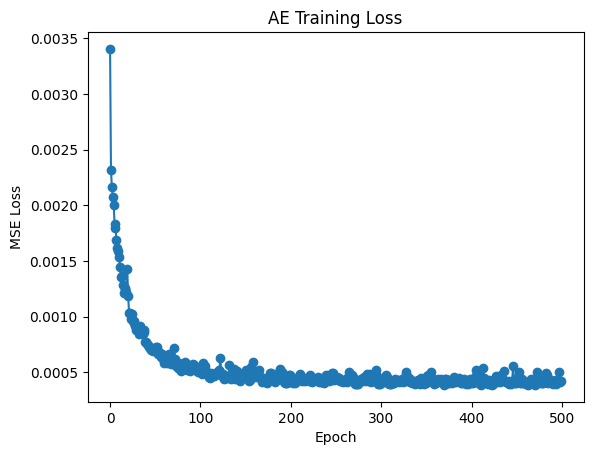

In [11]:
plt.figure()
plt.plot(history, marker='o')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('AE Training Loss')
plt.show()

## Inference & AUC on Embeddings

In [12]:
ae.eval()
scores, labels = [], []
with torch.no_grad():
    for x, y in tqdm(test_dl, desc='Inference'):
        x = x.to(DEVICE)
        recon = ae(x)
        err = ((x - recon)**2).mean(dim=1).cpu().numpy()
        scores.extend(err.tolist())
        labels.extend(y.tolist())
auc = roc_auc_score(labels, scores)
print('AUC:', auc)

Inference: 100%|██████████| 18/18 [00:10<00:00,  1.75it/s]

AUC: 0.6597836038285476


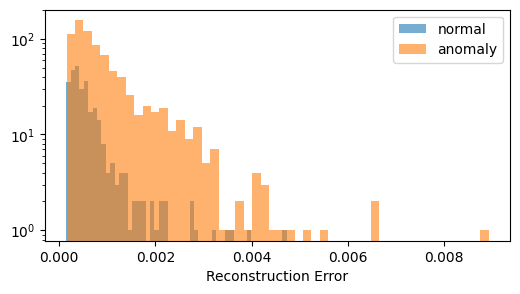

In [13]:
normal = np.array([s for s,l in zip(scores,labels) if l==0])
anom   = np.array([s for s,l in zip(scores,labels) if l==1])
plt.figure(figsize=(6,3))
plt.hist(normal, bins=50, alpha=0.6, label='normal', log=True)
plt.hist(anom, bins=50, alpha=0.6, label='anomaly', log=True)
plt.xlabel('Reconstruction Error')
plt.legend()
plt.show()